# Статистические и вероятностные методы обнаружения аномалий

In [2]:
# Импортируем необходимые библиотеки
import warnings

warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.covariance import EllipticEnvelope
%matplotlib inline

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Потренируемся на бостонском датасете. Данные о ценах на дома в Бостоне, сам датасет включает в себя следующие колонки:

- CRIM: Per capita crime rate by town
- ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
- INDUS: Proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: Nitric oxide concentration (parts per 10 million)
- RM: Average number of rooms per dwelling
- AGE: Proportion of owner-occupied units built prior to 1940
- DIS: Weighted distances to five Boston employment centers
- RAD: Index of accessibility to radial highways
- TAX: Full-value property tax rate per \$10,000
- PTRATIO: Pupil-teacher ratio by town
- B: 1000(Bk — 0.63)², where Bk is the proportion of black people by town
- LSTAT: Percentage of lower status of the population
- MEDV: Median value of owner-occupied homes in \$1000s

In [3]:
# Загрузим данные, возьмем 2 группы признаков: RAD и PTRATIO
X1 = boston_data.values[:, [8, 10]]

# RM и LSTAT
X2 = boston_data.values[:, [5, 12]]

## Поиск аномалий с помощью BoxPlot и IQR

<Axes: >

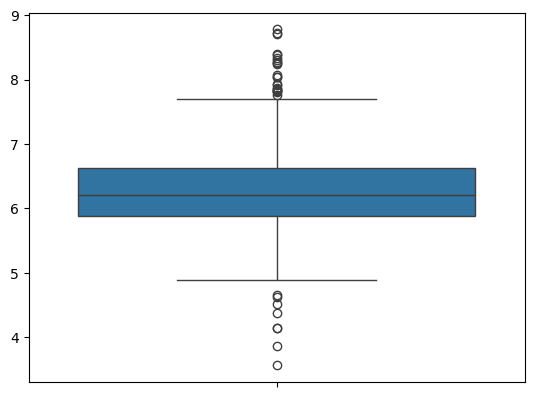

In [4]:
# Построим BoxPlot по признакам из X2 и посмотрим, есть ли выбросы
sns.boxplot(X2[:, 0])

Мы видим, что дома с >8 квартирами могут быть восприняты как выбросы

<Axes: >

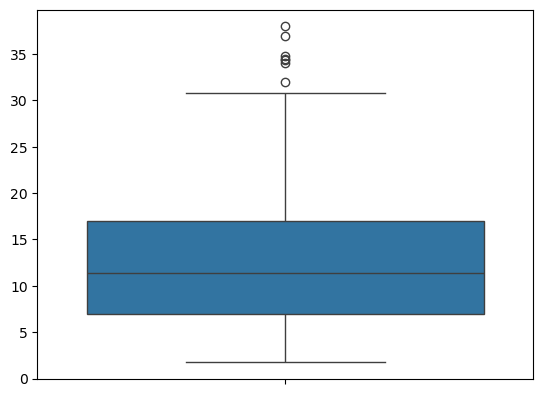

In [5]:
sns.boxplot(X2[:, 1])

Видим, что районы, в которых бедного населения > 30% тоже можно рассматривать как выбросы

In [6]:
# Чтобы посчитать IQR отдельно от графика, можно воспользоваться либо numpy, либо scipy
iqr = np.percentile(X2[:, 1], 75) - np.percentile(X2[:, 1], 25)
print(iqr)

import scipy
iqr = scipy.stats.iqr(X2[:, 1])
print(iqr)

10.005000000000003
10.005000000000003


# Оценка распределения и дисперсии распределения для поиска аномалий

Давайте оценим дисперсии выборок в предположении о нормальном распределении

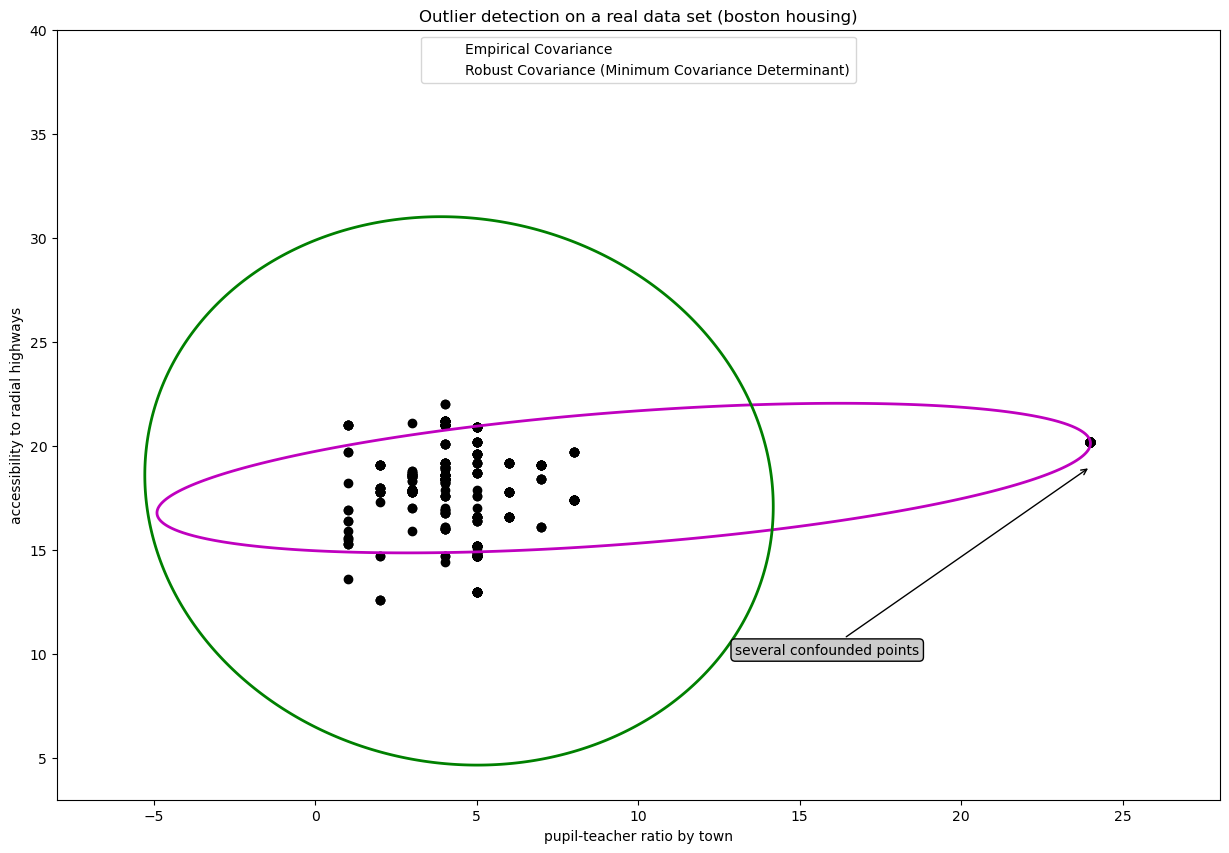

In [7]:
# Алгоритмы оценки ковариационной матрицы
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261)}

colors = ['m', 'g', 'b']

plt.subplots(figsize=(15, 10))
legend1 = {}
legend2 = {}

# Код для визуализации
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list( legend1.values() )
legend1_keys_list = list( legend1.keys() )

plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1]),
           loc="upper center")
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town");

In [11]:
boston_data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [20]:
df1 = boston_data['RAD']
df2 = boston_data['PTRATIO']

In [27]:
iqr = np.percentile(df1, 75) - np.percentile(df1, 25)
c = df1[(df1<(np.percentile(df1, 25) - 1.5*iqr))|(df1>(np.percentile(df1, 75) + 1.5*iqr))]
print(c.shape[0])

0


In [33]:
iqr = np.percentile(df2, 75) - np.percentile(df2, 25)
c = df2[(df2<(np.percentile(df2, 25) - 1.5*iqr))|(df2>(np.percentile(df2, 75) + 1.5*iqr))]
print(set(c))

{12.6, 13.0}
